In [1]:
import torch
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import os
import glob
import xarray as xr
from sklearn import preprocessing
import netCDF4 as nc
import matplotlib.pyplot as plt


np.random.seed(14)  # For reproducibility
torch.manual_seed(14)  # For reproducibility

BASE = '/scratch/ab10313/pleiades/'
PATH_NN = BASE+'NN_data_smooth/'

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataloader

### Create input and output channels

In [3]:
# load preprocessed data into input and output channels



# X INPUT
grad_B = np.load(PATH_NN+'grad_B.npy')
HML = np.load(PATH_NN+'HML.npy')
TAU = np.load(PATH_NN+'TAU.npy')
U = np.load(PATH_NN+'U.npy')
V = np.load(PATH_NN+'V.npy')
Q = np.load(PATH_NN+'Q.npy')
HBL = np.load(PATH_NN+'HBL.npy')
FCOR = np.load(PATH_NN+'FCOR.npy')


X_input = np.stack([FCOR, grad_B, HML, TAU, U, V, Q, HBL],axis=1)
print('X input shape:')
print( X_input.shape)
print('')


# Y OUTPUT
WB_sg = np.load(PATH_NN+'WB_sg.npy')
WB_sg_mean = np.load(PATH_NN+'WB_sg_mean.npy')
WB_sg_std = np.load(PATH_NN+'WB_sg_std.npy')
              
Y_output = np.tile(WB_sg,(1,1,1,1)).reshape(WB_sg.shape[0],1,WB_sg.shape[1],WB_sg.shape[2]) 
print('Y output shape:')
print(Y_output.shape)
print('')

np.isnan(X_input).any()
np.isnan(Y_output).any()

X input shape:
(8450, 8, 40, 40)

Y output shape:
(8450, 1, 40, 40)



False

### randomly generate train, test and validation sets

In [4]:
# TRAIN AND TEST ONLY
# randomnly generate train, test and validation time indecies 
import random
time_ind = X_input.shape[0]
rand_ind = np.arange(time_ind)
rand_seed = 14
random.Random(rand_seed).shuffle(rand_ind)
train_percent = 0.9
test_percent = 0.1 
print(f"Dataset: train {np.round(train_percent*100)}%, test {np.round(test_percent*100)}%")
train_ind, test_ind =  rand_ind[:round(train_percent*time_ind)], rand_ind[round((train_percent)*time_ind):]                                                                        

# check no overlapping indecies
if np.intersect1d(train_ind, test_ind).any():
    print('overlapping indecies')
else:
    print ('no overlapping indecies')
    

Dataset: train 90.0%, test 10.0%
no overlapping indecies


### defined train, test and val dataloaders

In [5]:
# Define X,Y pairs (state, subgrid fluxes) for local network.local_torch_dataset = Data.TensorDataset(
BATCH_SIZE = 64  # Number of sample in each batch


###### training dataset #######
torch_dataset_train = Data.TensorDataset(
    torch.from_numpy(X_input[train_ind]).double(),
    torch.from_numpy(Y_output[train_ind]).double(),
)

loader_train = Data.DataLoader(
    dataset=torch_dataset_train, batch_size=BATCH_SIZE, shuffle=True
)
print('TRAIN')
print('X input shape:')
print( X_input[train_ind].shape)
print('Y output shape:')
print( Y_output[train_ind].shape)
print('')

###### test dataset #######
torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(X_input[test_ind]).double(),
    torch.from_numpy(Y_output[test_ind]).double(),    
)

BATCH_SIZE_TEST = len(torch_dataset_test)

loader_test = Data.DataLoader(
    dataset=torch_dataset_test, batch_size=BATCH_SIZE_TEST, shuffle=False
)

print('TEST')
print('X input shape:')
print( X_input[test_ind].shape)
print('Y output shape:')
print( Y_output[test_ind].shape)
print('')



TRAIN
X input shape:
(7605, 8, 40, 40)
Y output shape:
(7605, 1, 40, 40)

TEST
X input shape:
(845, 8, 40, 40)
Y output shape:
(845, 1, 40, 40)



## CNN - direct fluxes 3 output channels

In [6]:
# define network structure in pytorch
import torch.nn.functional as FF

class CNN_direct(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(8, 128, 5, padding='same', padding_mode='reflect')  # 7 inputs, 128 neurons for first hidden layer
        self.conv1_bn=nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, 5, padding='same', padding_mode='reflect')  # 128 inputs, 64 neurons for first hidden layer
        self.conv2_bn=nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 48, 5, padding='same', padding_mode='reflect')  # 64 inputs, 32 neurons for first hidden layer
        self.conv3_bn=nn.BatchNorm2d(48)  
        self.conv4 = nn.Conv2d(48, 32, 5, padding='same', padding_mode='reflect')  # 32 inputs, 16 neurons for first hidden layer
        self.conv4_bn=nn.BatchNorm2d(32) 
        self.conv5 = nn.Conv2d(32, 16, 5, padding='same', padding_mode='reflect')  # 64 inputs, 32 neurons for first hidden layer
        self.conv5_bn=nn.BatchNorm2d(16)  
        self.conv6 = nn.Conv2d(16, 8, 5, padding='same', padding_mode='reflect')  # 32 inputs, 16 neurons for first hidden layer
        self.conv6_bn=nn.BatchNorm2d(8) 
        self.conv7 = nn.Conv2d(8, 1, 5, padding='same', padding_mode='reflect')  # 16 inputs, 1 neurons for first hidden layer
        self.conv7_bn=nn.BatchNorm2d(1) 

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.conv1_bn(x))
        x = self.conv2(x)
        x = F.relu(self.conv2_bn(x))
        x = self.conv3(x)
        x = F.relu(self.conv3_bn(x))
        x = self.conv4(x)
        x = F.relu(self.conv4_bn(x))
        x = self.conv5(x)
        x = F.relu(self.conv5_bn(x))
        x = self.conv6(x)
        x = F.relu(self.conv6_bn(x))
        x = self.conv7(x)
        x = self.conv7_bn(x)
        return x
 
    


## Train and test model: direct fluxes

In [39]:
# train network 
def train_model_direct(net, criterion, trainloader, optimizer, len_train_dataset, text="train"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
    print(f"Training starts on device {device_name}, number of samples {len(trainloader)}")
    
    net.train()
    train_loss = 0
    for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
        b_x = Variable(batch_x)  # Inputs
        b_y = Variable(batch_y)  # outputs
        prediction = net(b_x.to(device))
        loss = criterion(prediction, b_y.to(device))  # Calculating loss
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients to update weights
        nb = b_y.shape[0]
        train_loss = train_loss + nb * loss.detach().cpu().numpy()  # Keep track of the loss
    train_loss /= len_train_dataset  # dividing by the number of batches
    print(text + " loss:", train_loss)
    return train_loss


def test_model_direct(net, criterion, testloader, optimizer,len_test_dataset, text="test"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
    print(f"Training starts on device {device_name}, number of samples {len(testloader)}")
    
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(
            testloader
        ):  # for each training step
            b_x = Variable(batch_x)  # Inputs
            b_y = Variable(batch_y)  # outputs
            prediction = net(b_x.to(device))
            loss = criterion(prediction, b_y.to(device))  # Calculating loss
            nb = b_y.shape[0]
            test_loss = test_loss + nb * loss.detach().cpu().numpy()  # Keep track of the loss
        test_loss /= len_test_dataset  # dividing by the number of batches
        #         print(len(trainloader))
        print(text + " loss:", test_loss)
    return test_loss



def plot_model_direct(net, criterion, testloader, len_test_dataset, text="test"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
    print(f"Training starts on device {device_name}, number of samples {len(testloader)}")
    
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    #with torch.no_grad():
    for step, (batch_x, batch_y) in enumerate(
        testloader
    ):  # for each training step
        b_x = Variable(batch_x, requires_grad=True)  # Inputs
        b_y = Variable(batch_y)  # outputs
        prediction = net(b_x.to(device))
        loss = criterion(prediction, b_y.to(device))  # Calculating loss
        nb = b_y.shape[0]
        test_loss = test_loss + nb * loss.detach().cpu().numpy()  # Keep track of the loss
    test_loss /= len_test_dataset  # dividing by the number of batches
    #         print(len(trainloader))
    print(text + " loss:", test_loss)
    return b_x, b_y, prediction


criterion = torch.nn.MSELoss()  # MSE loss function




## train CNN!

In [8]:
torch.manual_seed(14)  # For reproducibility
cnn_submeso = CNN_direct().double()

n_epochs = 100  # Number of epocs could be increased
optimizer = optim.Adam(cnn_submeso.parameters(), lr=0.1)
test_loss = list()
train_loss = list()
for epoch in range(1, n_epochs + 1):
    print("epoch:", epoch)
    train_loss.append(train_model_direct(cnn_submeso, criterion, loader_train, optimizer,len(torch_dataset_train)))
    test_loss.append(test_model_direct(cnn_submeso, criterion, loader_test, optimizer,len(torch_dataset_test)))

torch.save(cnn_submeso, PATH_NN+'cnn_7l_k5_more_data.pth')

epoch: 1
Training starts on device Quadro RTX 8000, number of samples 119
train loss: 0.8251161618481393
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.7787913606411213
epoch: 2
Training starts on device Quadro RTX 8000, number of samples 119
train loss: 0.7634972137960055
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.7766909568639883
epoch: 3
Training starts on device Quadro RTX 8000, number of samples 119
train loss: 0.7257400363567302
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.6926198366593557
epoch: 4
Training starts on device Quadro RTX 8000, number of samples 119
train loss: 0.670388575319088
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.6380634896926571
epoch: 5
Training starts on device Quadro RTX 8000, number of samples 119
train loss: 0.63130848290173
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.6417838919485511
epoch: 6
Trai

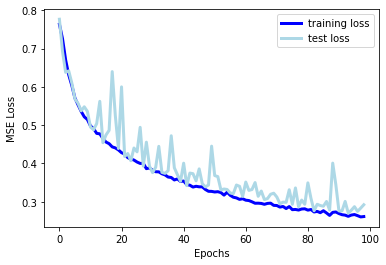

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_loss[1:], "b", linewidth=3,label="training loss")
plt.plot(test_loss[1:], "lightblue",linewidth=3, label="test loss")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend();

In [8]:
cnn_submeso = torch.load(PATH_NN+'cnn_7l_k5_more_data.pth')


In [27]:
cnn_submeso

CNN_direct(
  (conv1): Conv2d(8, 128, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
  (conv1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 48, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
  (conv3_bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(48, 32, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
  (conv4_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
  (conv5_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(16, 8, kernel

In [9]:
total_params = sum(
	param.numel() for param in cnn_submeso.parameters()
)
total_params


362691

In [40]:
b_x, b_y, prediction = plot_model_direct(cnn_submeso, criterion, loader_test,len(torch_dataset_test))

Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.2922765019871396


In [32]:
prediction.shape

torch.Size([845, 1, 40, 40])

In [41]:
def Jacobian_norm(x,y):
  if y.shape[1] != 1:
    print('Sorry')
  
  dydx = torch.zeros(x.shape[1])

  grad = torch.autograd.grad(
    outputs=y, inputs=x,
    grad_outputs=torch.ones_like(y),
    retain_graph=True, create_graph=True)[0]
      
  if grad.shape != x.shape:
    print('Error in dimensions')

  return torch.mean(grad**2, dim=[-2,-1]).mean(dim=0)

In [42]:
jacobian = Jacobian_norm(b_x,prediction)

<BarContainer object of 8 artists>

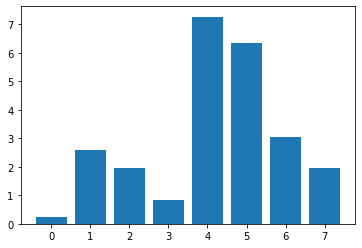

In [48]:
plt.bar(np.arange(8),jacobian.detach())

In [ ]:
FCOR, grad_B, HML, TAU, U, V, Q, HBL

In [11]:
# compare with FK
WB_FK = np.load(PATH_NN+'WB_FK.npy')
WB_FK_test = WB_FK[test_ind]

# compare with FK_Lf
Lf_FK11 = np.load(PATH_NN+'Lf_FK11.npy')
Lf_FK11_test = Lf_FK11[test_ind]

# compare with Bod_Lf
Lf_BD23 = np.load(PATH_NN+'Lf_BD23.npy')
Lf_BD23_test = Lf_BD23[test_ind]

# renormalize using mean and std 
WB_sg_mean_test = WB_sg_mean[test_ind]
WB_sg_std_test = WB_sg_std[test_ind] 

In [12]:
from scipy import stats

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

corr_pred_wb = stats.pearsonr(cnn_submeso(b_x.to(device)).detach().cpu().numpy().flatten(), b_y.flatten())

print("correlation between prediction and target,  w'b':",corr_pred_wb )

correlation between prediction and target,  w'b': (0.8527765728920924, 0.0)


<function matplotlib.pyplot.show(close=None, block=None)>

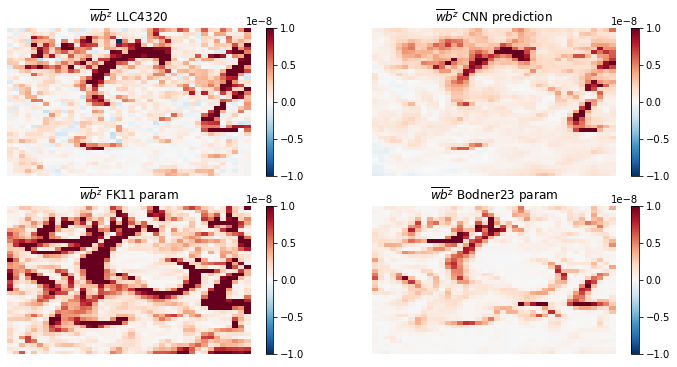

In [316]:
# visualize
it =720


mean_it = WB_sg_mean_test[it]
std_it = WB_sg_std_test[it]

plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
#fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplot(222)
plt.pcolor((cnn_submeso(b_x.to(device)).detach().cpu().numpy()[it,0,:,:])*std_it + mean_it,cmap='RdBu_r', vmin=-1e-8, vmax=1e-8)
plt.title('$\overline{wb}^z$ CNN prediction',fontsize = 12)
plt.colorbar()
plt.axis('off')

plt.subplot(221)
plt.pcolor((b_y[it,0,:,:])*std_it + mean_it,cmap='RdBu_r',vmin=-1e-8, vmax=1e-8)
plt.title('$\overline{wb}^z$ LLC4320',fontsize = 12)
plt.colorbar()
plt.axis('off')

plt.subplot(223)
plt.pcolor((0.07*25e3/np.maximum(Lf_FK11_test[it],5000))*WB_FK_test[it],cmap='RdBu_r',vmin=-1e-8, vmax=1e-8)
plt.title('$\overline{wb}^z$ FK11 param',fontsize = 12)
plt.colorbar()
plt.axis('off')

plt.subplot(224)
plt.pcolor((0.07*25e3/(Lf_BD23_test[it]))*WB_FK_test[it],cmap='RdBu_r',vmin=-1e-8, vmax=1e-8)
plt.title('$\overline{wb}^z$ Bodner23 param',fontsize = 12)
plt.colorbar()
plt.axis('off')
plt.show
#plt.savefig(BASE+'plots/cnn_prediction_snapshot_.png')

In [13]:
b_y.detach().cpu().numpy().shape

(845, 1, 40, 40)

In [14]:
mean_tile = np.transpose(np.tile(WB_sg_mean_test,(40,40,1,1)))
std_tile = np.transpose(np.tile(WB_sg_std_test,(40,40,1,1)))

Text(0.5, 0, '$\\overline{wb}^z$')

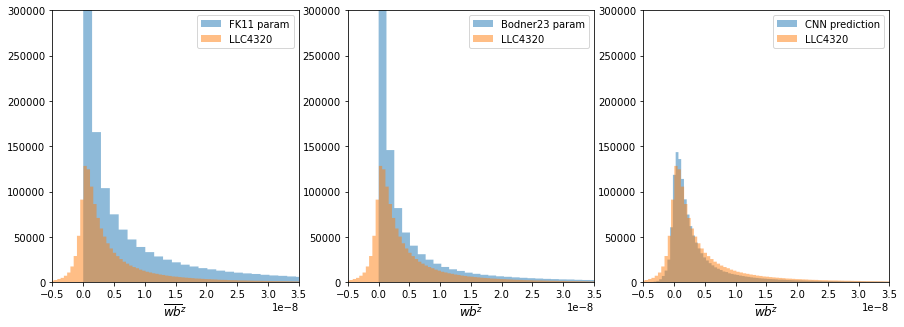

In [15]:
plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

plt.subplot(131)
_=plt.hist(((0.07*25e3/np.maximum(Lf_FK11_test[:],5000))*WB_FK_test[:]).flatten(),bins=1000,alpha=0.5,histtype='stepfilled',label="FK11 param")
_=plt.hist((b_y.detach().cpu().numpy()*std_tile + mean_tile).flatten(),bins=1000,alpha=0.5,histtype='stepfilled',label="LLC4320")
plt.xlim([-.5e-8,3.5e-8])
plt.ylim([0,3e5])
plt.legend()
plt.xlabel('$\overline{wb}^z$',fontsize=12)

plt.subplot(132)
_=plt.hist(((0.07*25e3/np.maximum(Lf_BD23_test[:],5000))*WB_FK_test[:]).flatten(),bins=1000,alpha=0.5,histtype='stepfilled',label="Bodner23 param")
_=plt.hist((b_y.detach().cpu().numpy()*std_tile + mean_tile).flatten(),bins=1000,alpha=0.5,histtype='stepfilled',label="LLC4320")
plt.xlim([-.5e-8,3.5e-8])
plt.ylim([0,3e5])
plt.legend()
plt.xlabel('$\overline{wb}^z$',fontsize=12)


plt.subplot(133)
_=plt.hist((cnn_submeso(b_x.to(device)).detach().cpu().numpy()*std_tile + mean_tile).flatten(),bins=1000,alpha=0.5,histtype='stepfilled',label="CNN prediction")
_=plt.hist((b_y.detach().cpu().numpy()*std_tile + mean_tile).flatten(),bins=1000,alpha=0.5,histtype='stepfilled',label="LLC4320")
plt.xlim([-.5e-8,3.5e-8])
plt.ylim([0,3e5])
plt.legend()
plt.xlabel('$\overline{wb}^z$',fontsize=12)



#plt.savefig(BASE+'plots/cnn_prediction_hist.png')
#plt.xlabel('$\overline{wb}^z$')


In [18]:
target_da = xr.DataArray((b_y.detach().cpu().numpy()*std_tile + mean_tile), dims=["time", "axis", "i","j"])[:,0,:,:]
param_FK11_da = xr.DataArray((0.07*25e3/np.maximum(Lf_FK11_test[:],5000))*WB_FK_test[:], dims=["time", "i","j"])
param_BD23_da = xr.DataArray((0.07*25e3/np.maximum(Lf_BD23_test[:],5000))*WB_FK_test[:], dims=["time", "i","j"])
prediction_da = xr.DataArray((cnn_submeso(b_x.to(device)).detach().cpu().numpy()*std_tile + mean_tile), dims=["time", "axis", "i","j"])[:,0,:,:]

In [19]:
import xrft

# target vs prediction spectra

WsBs_target_spectra = xrft.isotropic_power_spectrum(target_da,dim=['i','j'], 
                                           detrend='linear', window=True).compute().mean('time')

WsBs_prediction_spectra = xrft.isotropic_power_spectrum(prediction_da,dim=['i','j'], 
                                           detrend='linear', window=True).compute().mean('time')

WsBs_param_FK11_spectra = xrft.isotropic_power_spectrum(param_FK11_da,dim=['i','j'], 
                                           detrend='linear', window=True).compute().mean('time')

WsBs_param_BD23_spectra = xrft.isotropic_power_spectrum(param_BD23_da,dim=['i','j'], 
                                           detrend='linear', window=True).compute().mean('time')



/home/ab10313/.local/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home/ab10313/.local/lib/python3.9/site-packages/xrft/xrft.py:1025: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/home/ab10313/.local/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home/ab10313/.local/lib/python3.9/site-packages/xrft/xrft.py:1025: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/home/ab10313/.local/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be de

Text(0.5, 1.0, 'WsBs')

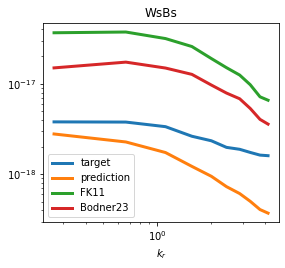

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(4, 10))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplot(311)
#plt.loglog(WsBs_target_spectra.freq_r*2*np.pi, 5e-3*WsBs_target_spectra.freq_r**-2, '--',linewidth=1.5,color='black', label='k^{-2}')
#plt.loglog(WsBs_target_spectra.freq_r*2*np.pi, 2e-3*WsBs_target_spectra.freq_r**-3, '--',linewidth=1.5,color='gray', label='k^{-3}')
plt.loglog(WsBs_target_spectra.freq_r*2*np.pi, WsBs_target_spectra,linewidth=3, label='target')
plt.loglog(WsBs_target_spectra.freq_r*2*np.pi, WsBs_prediction_spectra,linewidth=3, label='prediction')
plt.loglog(WsBs_target_spectra.freq_r*2*np.pi, WsBs_param_FK11_spectra,linewidth=3, label='FK11')
plt.loglog(WsBs_target_spectra.freq_r*2*np.pi, WsBs_param_BD23_spectra,linewidth=3, label='Bodner23')
#plt.loglog(WsBs_target_spectra.freq_r*2*np.pi, WsBs_param_BD_spectra*WsBs_target_spectra.freq_r,linewidth=3, label='BD23')



plt.legend()
plt.xlabel('$k_r$')
#plt.ylabel('Normalized isotropic spectra')
plt.title('WsBs')
#plt.ylim([1e-3,1e-1])

In [24]:
np.save(PATH_NN+'test_prediction_7L_k7.npy',cnn_submeso(b_x.to(device)).detach().cpu().numpy()[:,0,:,:])
np.save(PATH_NN+'test_target_7L_k7.npy',b_y[:,0,:,:])
np.save(PATH_NN+'test_WB_FK.npy',WB_FK_test)


In [50]:
test_prediction = np.load(PATH_NN+'test_prediction_7L_k7.npy')
test_target = np.load(PATH_NN+'test_target_7L_k7.npy')
test_FK = np.load(PATH_NN+'test_WB_FK.npy')


NameError: name 'test_prediction' is not defined

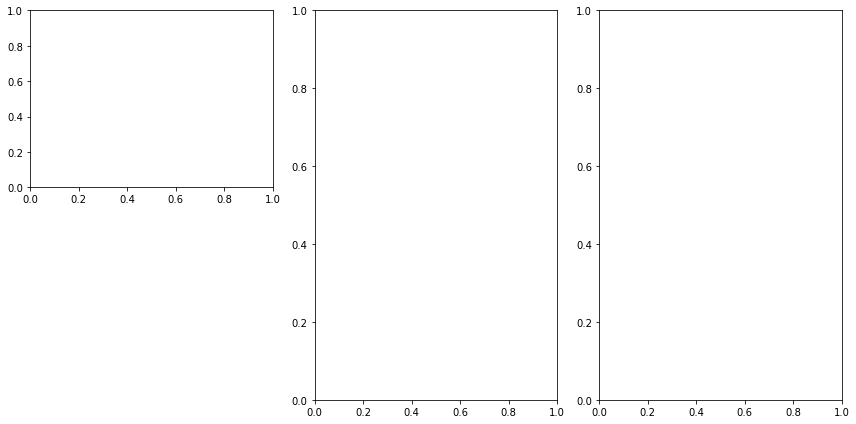

In [25]:
# visualize
it =2

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplot(231)
plt.pcolor(test_prediction[it],cmap='coolwarm',vmin=-1.5,vmax =1.5)
plt.title('wb prediction')
plt.colorbar()
plt.axis('off')

plt.subplot(232)
plt.pcolor(test_target[it,:,:],cmap='coolwarm',vmin=-1.5,vmax =1.5)
plt.title('wb target')
plt.colorbar()
plt.axis('off')

plt.subplot(233)
plt.pcolor(test_FK[it],cmap='coolwarm',vmin=-1.5,vmax =1.5)
plt.title('wb FK')
plt.colorbar()
plt.axis('off')


(0.0, 40.0, 0.0, 40.0)

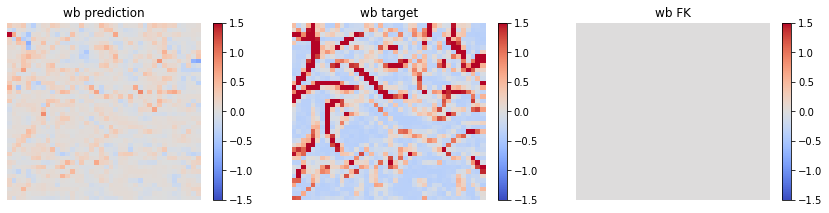

In [43]:
# visualize
it =2

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplot(231)
plt.pcolor(test_prediction[it]-test_target[it,:,:],cmap='coolwarm',vmin=-1.5,vmax =1.5)
plt.title('wb prediction')
plt.colorbar()
plt.axis('off')

plt.subplot(232)
plt.pcolor(test_target[it,:,:],cmap='coolwarm',vmin=-1.5,vmax =1.5)
plt.title('wb target')
plt.colorbar()
plt.axis('off')

plt.subplot(233)
plt.pcolor(test_FK[it]-test_target[it,:,:],cmap='coolwarm',vmin=-1.5,vmax =1.5)
plt.title('wb FK')
plt.colorbar()
plt.axis('off')


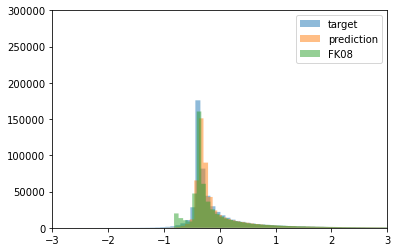

In [37]:
_=plt.hist(test_target.flatten(),bins=500,alpha=0.5,histtype='stepfilled',label="target")
_=plt.hist(test_prediction.flatten(),bins=500,alpha=0.5,histtype='stepfilled',label="prediction")
_=plt.hist(WB_FK_test.flatten(),bins=500,alpha=0.5,histtype='stepfilled',label="FK08")


plt.ylim([0,.3e6])
plt.xlim([-3,3])
plt.legend()